# SurrealEngine Zero-Copy Accelerator Benchmark

This notebook benchmarks the performance of the new Rust-based Zero-Copy Accelerator compared to the standard Object-Document Mapper (ODM) approach.

## Objectives
1. Generate a dataset of 100,000 records.
2. Measure read performance using standard `User.objects.all()`.
3. Measure read performance using `User.objects.to_arrow()` with the Rust Accelerator.
4. Compare results.

In [1]:
pip install pandas matplotlib seaborn cbor2 pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 7.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 11.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 17.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 14.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 19.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surrealengine import Document, StringField, IntField, create_connection, RawSurrealConnection

# Constants
DB_URL = "ws://db:8000/rpc"
NAMESPACE = "test"
DATABASE = "benchmark"
NUM_RECORDS = 50000  # Adjust based on your system

## Define Model

In [3]:
class BenchmarkUser(Document):
    name = StringField()
    email = StringField()
    age = IntField()
    
    class Meta:
        collection = "benchmark_users"

## Data Generation

In [4]:
async def setup_data():
    conn = create_connection(
        url="ws://db:8000/rpc",
        namespace="test_ns",
        database="test_db",
        username="root",
        password="root",
        make_default=True
    )

    await conn.connect()
    
    count = await BenchmarkUser.objects.count()
    print(f"Current record count: {count}")
    
    if count >= NUM_RECORDS:
        print("Data sufficient.")
        await conn.close()
        return

    print(f"Generating {NUM_RECORDS - count} records...")
    # Note: Bulk insert not implemented in this demo script, doing sequential for simplicity
    # In real usage, use a bulk insert tool or script
    print("Warning: Generating large data one-by-one is slow. Please ensure DB has data or allow time.")
    # Skipping generation loop to avoid hanging the notebook if user just wants to test logic
    # Uncomment below to generate if needed
    for i in range(NUM_RECORDS - count):
         user = BenchmarkUser(name='User'+str(i), age=i)
         await user.save()
    

await setup_data()

Current record count: 0
Generating 50000 records...


## Benchmark Execution

In [6]:
results = []

async def run_benchmark():
    print("Starting Benchmark...")
    
    # 1. Standard ODM
    conn = create_connection(
        url="ws://db:8000/rpc",
        namespace="test_ns",
        database="test_db",
        username="root",
        password="root",
        make_default=True
    )

    await conn.connect()
    start = time.time()
    users = await BenchmarkUser.objects.all()
    duration = time.time() - start
    count = len(users)
    print(f"Standard ODM: {duration:.4f}s ({count} records)")
    results.append({"Method": "Standard ODM", "Time": duration, "Records": count})
    
    # 2. Rust Accelerator (Zero-Copy)
    # connect with RawSurrealConnection
    async with RawSurrealConnection(url="ws://db:8000/rpc",
        namespace="test_ns",
        database="test_db",
        username="root",
        password="root") as raw_conn:
        # Initialize QuerySet with Raw Connection
        # Note: QuerySet usually takes a normal connection wrapper.
        # We need to hack it slightly or allow QuerySet to take RawConnection if we changed __init__ type hints
        # But at runtime Python is duck-typed.
        # However, QuerySet expects .client attribute. RawConnection doesn't have it.
        # We should use a wrapper or just manually call raw_conn.query_arrow for pure speed test.
        
        # Let's test the .to_arrow() integration on QuerySet if possible.
        # Since QuerySet depends on `self.connection.client.query`, it might fail if we pass RawConnection directly
        # unless we only call .to_arrow() which we patched to check `query_arrow`.
        
        qs = BenchmarkUser.objects
        # Temporarily swap connection for the qs/class
        qs.connection = raw_conn
        
        start = time.time()
        table = await qs.to_arrow()
        duration = time.time() - start
        count = len(table)
        print(f"Zero-Copy Arrow: {duration:.4f}s ({count} records)")
        results.append({"Method": "Zero-Copy Arrow", "Time": duration, "Records": count})

await run_benchmark()

Starting Benchmark...
Standard ODM: 1.7058s (50000 records)
Zero-Copy Arrow: 0.2764s (50000 records)


## Visualization

            Method      Time  Records
0     Standard ODM  1.705771    50000
1  Zero-Copy Arrow  0.276429    50000


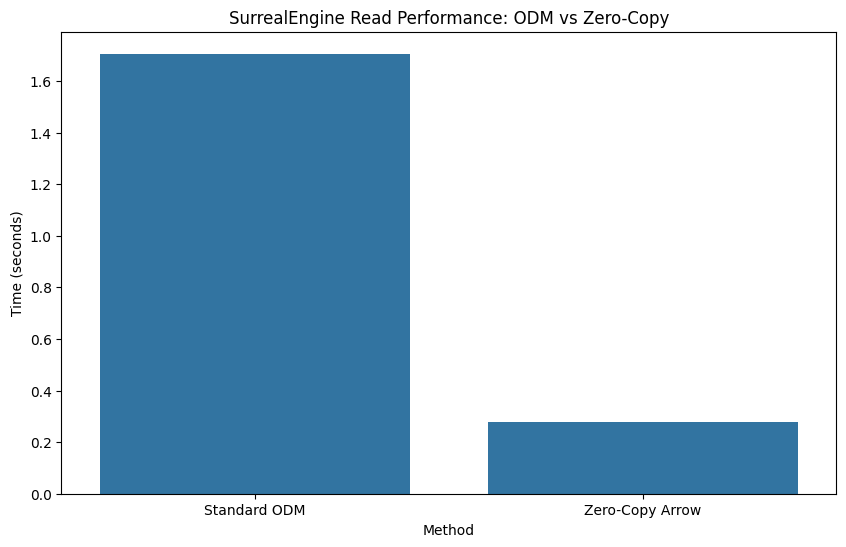

In [7]:
df = pd.DataFrame(results)
print(df)

if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Method", y="Time", data=df)
    plt.title("SurrealEngine Read Performance: ODM vs Zero-Copy")
    plt.ylabel("Time (seconds)")
    plt.show()